In [1]:
from __future__ import division, print_function
import os
import sys
from six.moves import cPickle as pickle

# Third-party
import astropy.coordinates as coord
import astropy.units as u
uno = u.dimensionless_unscaled
import matplotlib as mpl
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np

# Custom
import gary.coordinates as gc
import gary.dynamics as gd
import gary.integrate as gi
import gary.potential as gp
from gary.units import galactic
from scipy.signal import argrelmin

import ophiuchus.potential as op
from ophiuchus.data import OphiuchusData
from ophiuchus.util import integrate_forward_backward
from ophiuchus.coordinates import Ophiuchus
from ophiuchus import galactocentric_frame, vcirc, vlsr, RESULTSPATH

plotpath = "/Users/adrian/projects/ophiuchus-paper/figures/"
if not os.path.exists(plotpath):
    os.mkdir(plotpath)

In [2]:
ophdata = OphiuchusData()
all_names = ["static_mw"] + ["barred_mw_{}".format(i) for i in range(1,10)]
short_names = ["static"] + ["bar{}".format(i) for i in range(1,10)]
name_map = dict(zip(all_names, short_names))

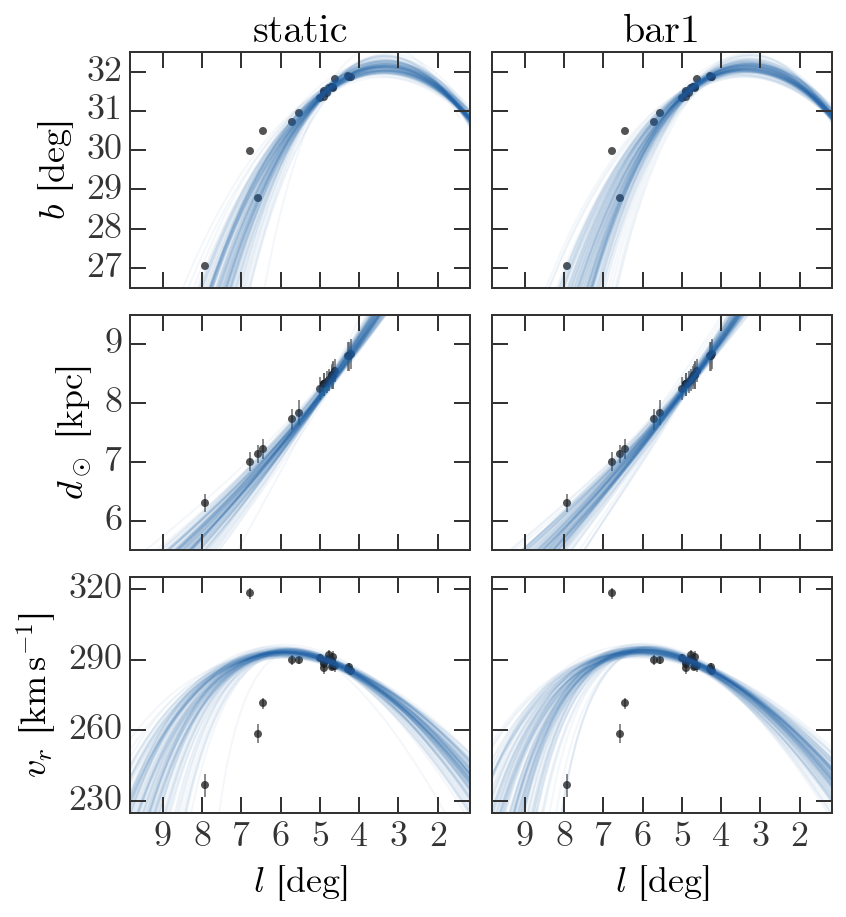

In [12]:
# global style stuff
orbit_style = dict(marker=None, color='#2166AC', alpha=0.05)
data_style = dict(marker='o', ms=4, ls='none', ecolor='#666666', alpha=0.75)
        
fig,axes = pl.subplots(3,2,figsize=(6,6.5),sharex=True,sharey='row')

for i,name in enumerate(all_names[:2]):
    axes[0,i].set_title(name_map[name], fontsize=20)
    axes[2,i].set_xlabel("$l$ [deg]", fontsize=18)
    
    axes[0,i].set_aspect('equal')

    path = os.path.join(RESULTSPATH, name, 'orbitfit')
    w0 = np.load(os.path.join(path, 'w0.npy'))[:128].T
    pot = op.load_potential(name)

    orbit = integrate_forward_backward(pot, w0, t_forw=20., t_back=-20)

    orbit_c,orbit_v = orbit.to_frame(coord.Galactic, galactocentric_frame=galactocentric_frame,
                                     vcirc=vcirc, vlsr=vlsr)
    orbit_l = orbit_c.l.wrap_at(180*u.deg)
    
    orbit_oph = orbit_c.transform_to(Ophiuchus)
    vr = (orbit_v[2].to(u.km/u.s)).value

    # sky
    _tmp = data_style.copy()
    _tmp.pop('ecolor')
    axes[0,i].plot(ophdata.coord.l.degree, ophdata.coord.b.degree, **_tmp)
    axes[0,i].plot(orbit_l.degree, orbit_c.b.degree, **orbit_style)
    axes[0,i].yaxis.set_ticks(np.arange(27,32+1))

    # distance
    axes[1,i].errorbar(ophdata.coord.l.degree, ophdata.coord.distance.to(u.kpc).value, 
                       ophdata.coord_err['distance'].to(u.kpc).value, **data_style)
    axes[1,i].plot(orbit_l.degree, orbit_c.distance.to(u.kpc).value, **orbit_style)
    axes[1,i].yaxis.set_ticks(np.arange(6,9+1))

    # radial velocity
    axes[2,i].errorbar(ophdata.coord.l.degree, ophdata.veloc['vr'].to(u.km/u.s).value, 
                       ophdata.veloc_err['vr'].to(u.km/u.s).value, **data_style)
    axes[2,i].plot(orbit_l.degree, np.vstack(vr), **orbit_style)
    axes[2,i].yaxis.set_ticks(np.arange(230,320+1,30))

axes[0,0].set_xlim(9,2)

axes[0,0].set_ylabel("$b$ [deg]", fontsize=18)
axes[0,0].set_ylim(26.5, 32.5)

axes[1,0].set_ylabel(r"$d_\odot$ [kpc]", fontsize=18)
axes[1,0].set_ylim(5.5, 9.5)

axes[2,0].set_ylabel(r"$v_r$ [${\rm km}\,{\rm s}^{-1}$]", fontsize=18)
axes[2,0].set_ylim(225, 325)

fig.tight_layout()

fig.savefig(os.path.join(plotpath, "orbitfits.pdf"))
fig.savefig(os.path.join(plotpath, "orbitfits.png"), dpi=400)

### Plot mean orbits in XYZ

In [4]:
split_ix = 350
every = 50

mean_w0s = np.zeros((len(all_names), 6))
for i,name in enumerate(all_names):
    with open(os.path.join(RESULTSPATH, name, 'orbitfit', 'sampler.pickle'), 'rb') as f:
        sampler = pickle.load(f)
    _x0 = np.vstack(sampler.chain[:,split_ix::every,:5])
    mean_x0 = np.mean(_x0, axis=0)
    std_x0 = np.std(_x0, axis=0)
    
    transforms = [
        lambda x: np.degrees(x),
        lambda x: x,
        lambda x: (x*u.radian/u.Myr).to(u.mas/u.yr).value,
        lambda x: (x*u.radian/u.Myr).to(u.mas/u.yr).value,
        lambda x: (x*u.kpc/u.Myr).to(u.km/u.s).value
    ]
    cols = []
    for j,_mean,_std in zip(range(len(mean_x0)), mean_x0, std_x0):
        cols.append("{:.3f} {:.3f}".format(transforms[j](_mean), transforms[j](_std)))
    print(" & ".join(cols))
    
    mul = (mean_x0[2]*u.radian/u.Myr).to(u.mas/u.yr).value
    
    
    mean_w0s[i] = ophdata._mcmc_sample_to_w0(mean_x0)[:,0]

-0.032 0.051 & 8.353 0.054 & -7.223 0.093 & 0.927 0.102 & 289.177 0.940
-0.032 0.052 & 8.407 0.055 & -7.177 0.099 & 0.942 0.106 & 289.032 0.970
-0.032 0.052 & 8.399 0.048 & -7.182 0.104 & 0.943 0.118 & 289.006 0.977
-0.028 0.052 & 8.400 0.054 & -7.179 0.096 & 0.945 0.104 & 289.129 0.955
-0.034 0.053 & 8.412 0.053 & -7.177 0.097 & 0.937 0.106 & 289.039 1.002
-0.033 0.052 & 8.412 0.056 & -7.179 0.096 & 0.937 0.103 & 289.117 0.970
-0.029 0.053 & 8.404 0.048 & -7.181 0.100 & 0.941 0.109 & 289.097 0.979
-0.033 0.054 & 8.414 0.052 & -7.179 0.097 & 0.934 0.105 & 289.057 1.040
-0.026 0.053 & 8.418 0.056 & -7.175 0.103 & 0.937 0.105 & 289.075 1.020
-0.031 0.052 & 8.414 0.055 & -7.173 0.097 & 0.945 0.108 & 288.996 0.940


In [5]:
_tmp_cache = dict()

3.8388304404819142 kpc 12.406617707191186 kpc
3.994795169117654 kpc 13.546763085838291 kpc
3.9043590978742126 kpc 14.785797788343114 kpc
3.9453601221545536 kpc 12.057508159343474 kpc
3.9320105310969726 kpc 12.82945208311379 kpc
3.936222579350191 kpc 13.1276815568813 kpc
4.048989526973062 kpc 11.875394572686726 kpc
3.912338173668357 kpc 12.852330746403853 kpc
3.962326139403555 kpc 15.033617125655574 kpc
4.038299191116463 kpc 12.206923060670833 kpc


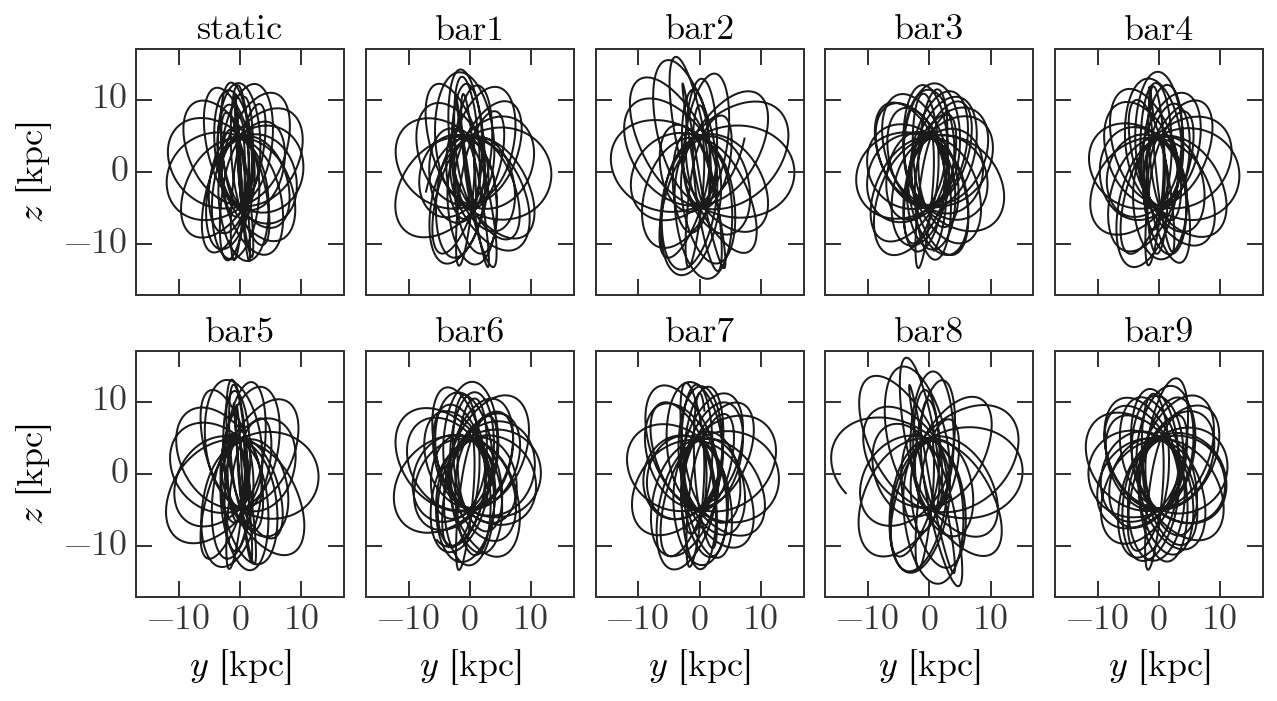

In [16]:
fig,axes = pl.subplots(2,5,figsize=(9,5),sharex=True,sharey=True)
for i,name in enumerate(all_names):
    this_w0 = mean_w0s[i]
    pot = op.load_potential(name)
    
    if name not in _tmp_cache:
        print("integrating")
        orbit = pot.integrate_orbit(this_w0, dt=-1., nsteps=6000., Integrator=gi.DOPRI853Integrator)
        _tmp_cache[name] = orbit
    else:
        orbit = _tmp_cache[name]
    
    print(orbit.pericenter(), orbit.apocenter())
    
    axes.flat[i].plot(orbit.pos[1], orbit.pos[2], marker=None)
    axes.flat[i].set_title(name_map[name], fontsize=18)

    if i > 4:
        axes.flat[i].set_xlabel("$y$ [kpc]", fontsize=18)

axes[0,0].set_ylabel("$z$ [kpc]", fontsize=18)
axes[1,0].set_ylabel("$z$ [kpc]", fontsize=18)

_s = 17
axes[0,0].set_xlim(-_s,_s)
axes[0,0].set_ylim(-_s,_s)

axes[0,0].xaxis.set_ticks([-10,0,10])
axes[0,0].yaxis.set_ticks([-10,0,10])

fig.tight_layout()

fig.savefig(os.path.join(plotpath, "orbit-yz.png"), dpi=300)
fig.savefig(os.path.join(plotpath, "orbit-yz.pdf"))

--- 

### Old plots

In [ ]:
# global style stuff
orbit_style = dict(marker=None, color='#2166AC', alpha=0.05)
data_style = dict(marker='o', ms=4, ls='none', ecolor='#666666', alpha=0.75)
        
for n,name_subset in enumerate([all_names[:5], all_names[5:]]):
    fig,axes = pl.subplots(3,5,figsize=(9,6.5),sharex=True,sharey='row')

    for i,name in enumerate(name_subset):
        axes[0,i].set_title(name_map[name], fontsize=20)
        axes[2,i].set_xlabel("$l$ [deg]", fontsize=18)

        path = os.path.join(RESULTSPATH, name, 'orbitfit')
        w0 = np.load(os.path.join(path, 'w0.npy'))[:128].T
        pot = op.load_potential(name)
    
        orbit = integrate_forward_backward(pot, w0, t_forw=16., t_back=-10)
        
        orbit_c,orbit_v = orbit.to_frame(coord.Galactic, galactocentric_frame=galactocentric_frame,
                                         vcirc=vcirc, vlsr=vlsr)
        orbit_oph = orbit_c.transform_to(Ophiuchus)
        vr = (orbit_v[2].to(u.km/u.s)).value

        # sky
        _tmp = data_style.copy()
        _tmp.pop('ecolor')
        axes[0,i].plot(ophdata.coord.l.degree, ophdata.coord.b.degree, **_tmp)
        axes[0,i].plot(orbit_c.l.degree, orbit_c.b.degree, **orbit_style)
        axes[0,i].yaxis.set_ticks(np.arange(27,32+1))

        # distance
        axes[1,i].errorbar(ophdata.coord.l.degree, ophdata.coord.distance.to(u.kpc).value, 
                           ophdata.coord_err['distance'].to(u.kpc).value, **data_style)
        axes[1,i].plot(orbit_c.l.degree, orbit_c.distance.to(u.kpc).value, **orbit_style)
        axes[1,i].yaxis.set_ticks(np.arange(6,9+1))

        # radial velocity
        axes[2,i].errorbar(ophdata.coord.l.degree, ophdata.veloc['vr'].to(u.km/u.s).value, 
                           ophdata.veloc_err['vr'].to(u.km/u.s).value, **data_style)
        axes[2,i].plot(orbit_c.l.degree, np.vstack(vr), **orbit_style)
        axes[2,i].yaxis.set_ticks(np.arange(230,320+1,30))

    axes[0,0].set_xlim(9,2)

    axes[0,0].set_ylabel("$b$ [deg]", fontsize=18)
    axes[0,0].set_ylim(26.5, 32.5)

    axes[1,0].set_ylabel(r"$d_\odot$ [kpc]", fontsize=18)
    axes[1,0].set_ylim(5.5, 9.5)

    axes[2,0].set_ylabel(r"$v_r$ [${\rm km}\,{\rm s}^{-1}$]", fontsize=18)
    axes[2,0].set_ylim(225, 325)

    fig.tight_layout()
    
#     fig.savefig(os.path.join(plotpath, "orbitfits-{}.pdf".format(n)))
#     fig.savefig(os.path.join(plotpath, "orbitfits-{}.png".format(n)))